In [1]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install -U -q automl-alex

In [1]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare
from automl_alex import CrossValidation
print(automl_alex.__version__)

1.2.27b


In [2]:
automl_alex.models.all_models

{'LightGBM': automl_alex.models.model_lightgbm.LightGBM,
 'KNeighbors': automl_alex.models.sklearn_models.KNeighbors,
 'LinearModel': automl_alex.models.sklearn_models.LinearModel,
 'SGD': automl_alex.models.sklearn_models.SGD,
 'RandomForest': automl_alex.models.sklearn_models.RandomForest,
 'ExtraTrees': automl_alex.models.sklearn_models.ExtraTrees,
 'XGBoost': automl_alex.models.model_xgboost.XGBoost,
 'CatBoost': automl_alex.models.model_catboost.CatBoost,
 'MLP': automl_alex.models.sklearn_models.MLP}

In [3]:
RANDOM_SEED = 42

## Data

In [4]:
# add dataset whis more num features
dataset = fetch_openml(name='credit-g', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((800, 20), (200, 20))

In [5]:
X_train.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,<0,60.0,delayed previously,business,6836.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes


In [6]:
de = DataPrepare(
    normalization=False, # if you use Linar based models -> True (for Tree based models normalization is not needed)
    random_state=RANDOM_SEED,
    )
X_train = de.fit_transform(X_train)
X_test = de.transform(X_test)
X_train.shape, X_test.shape

00:40:18 | Source data shape: (800, 20)
00:40:18 | ##################################################
00:40:18 | ! START preprocessing Data
00:40:18 | - Auto detect cat features: 13
00:40:18 | > Binary Features
00:40:18 | > Clean Categorical Features
00:40:18 | > Transform Categorical Features.
00:40:18 |  - Encoder: HelmertEncoder ADD features: 39
00:40:19 |  - Encoder: CountEncoder ADD features: 13
00:40:19 | > CleanOutliers
00:40:19 | Num of outlier detected: 10 in Feature duration
00:40:19 | Proportion of outlier detected: 1.2 %
00:40:19 | Num of outlier detected: 6 in Feature age
00:40:19 | Proportion of outlier detected: 0.8 %
00:40:19 | Num of outlier detected: 38 in Feature credit_amount
00:40:19 | Proportion of outlier detected: 4.8 %
00:40:19 |   No nans features
00:40:19 | > Generate interaction Num Features
00:40:19 |  ADD features: 45
00:40:19 | ##################################################
00:40:19 | Final data shape: (800, 123)
00:40:19 | Total ADD columns: 103
00:4

((800, 123), (200, 123))

In [7]:
X_train.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age_-_credit_amount,existing_credits_/_residence_since,existing_credits_*_residence_since,existing_credits_-_residence_since,existing_credits_/_credit_amount,existing_credits_*_credit_amount,existing_credits_-_credit_amount,residence_since_/_credit_amount,residence_since_*_credit_amount,residence_since_-_credit_amount
0,1,48.0,1,1,6836.0,1,1,3.0,1,1,...,-6773.0,0.50,8.0,-2.0,0.000293,13672.0,-6834.0,0.000585,27344.0,-6832.0
1,2,21.0,2,2,2319.0,1,2,2.0,2,1,...,-2286.0,1.00,1.0,0.0,0.000431,2319.0,-2318.0,0.000431,2319.0,-2318.0
2,3,6.0,3,3,1236.0,2,3,2.0,1,1,...,-1186.0,0.25,4.0,-3.0,0.000809,1236.0,-1235.0,0.003236,4944.0,-1232.0
3,3,21.0,4,4,5003.0,3,3,1.0,3,1,...,-4974.0,0.50,8.0,-2.0,0.000400,10006.0,-5001.0,0.000800,20012.0,-4999.0
4,3,12.0,3,5,886.0,3,3,4.0,3,1,...,-865.0,0.50,2.0,-1.0,0.001129,886.0,-885.0,0.002257,1772.0,-884.0


# Classifier

## Model

In [8]:
# Libraries are currently available:
automl_alex.models.all_models

{'LightGBM': automl_alex.models.model_lightgbm.LightGBM,
 'KNeighbors': automl_alex.models.sklearn_models.KNeighbors,
 'LinearModel': automl_alex.models.sklearn_models.LinearModel,
 'SGD': automl_alex.models.sklearn_models.SGD,
 'RandomForest': automl_alex.models.sklearn_models.RandomForest,
 'ExtraTrees': automl_alex.models.sklearn_models.ExtraTrees,
 'XGBoost': automl_alex.models.model_xgboost.XGBoost,
 'CatBoost': automl_alex.models.model_catboost.CatBoost,
 'MLP': automl_alex.models.sklearn_models.MLP}

You can add a library if you wish.    
let's try LightGBM

In [9]:
from automl_alex import LightGBM, LightGBMClassifier

# We will use LightGBM for this dataset
model = LightGBM(type_of_estimator='classifier', random_state=RANDOM_SEED)

# or Simply
model = LightGBMClassifier(random_state=RANDOM_SEED)

it's simple, the logic is like in sklearn (.fit() => .predict())

In [10]:
model.fit(X_train, y_train)

In [11]:
predicts = model.predict_proba(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.8062


In [12]:
# or just use .score()
score = model.score(
    X_test, y_test,
    metric=sklearn.metrics.roc_auc_score,
    metric_round=4,
    print_metric=True,
    )

00:40:28 | roc_auc_score: 0.8062


In [13]:
model.model_param

{'random_seed': 42,
 'num_iterations': 300,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary'}

In [14]:
feature_importance = model.get_feature_importance(X_train)

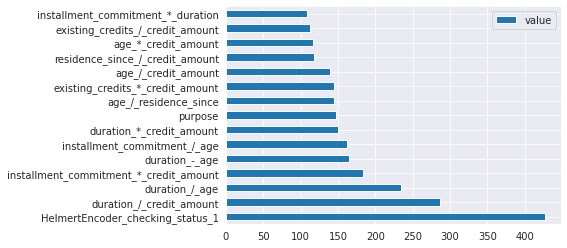

In [15]:
feature_importance.sort_values(by='value', ascending=False)[:15].plot(kind='barh')

### Save & Load

In [16]:
model.save('model_1',)

00:40:31 | Save Model


In [17]:
model_new = LightGBMClassifier(random_state=RANDOM_SEED)
model_new = model_new.load('model_1',)

predicts = model_new.predict_proba(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.8062


## Cross Validation
Cross-validation is a method for evaluating an analytical model and its behavior on independent data. 
When evaluating the model, the available data is split into k parts. 
Then the model is trained on k − 1 pieces of data, and the rest of the data is used for testing. 
The procedure is repeated k times; in the end, each of the k pieces of data is used for testing. 
The result is an assessment of the effectiveness of the selected model with the most even use of the available data.

<img src="./img/cv.png" width="600">

In [18]:
cv = CrossValidation(
        estimator=model,
        folds=10,
        score_folds=5,
        n_repeats=1,
        metric=sklearn.metrics.roc_auc_score,
        print_metric=False, 
        metric_round=4, 
        random_state=RANDOM_SEED
        )

In [19]:
score, score_std = cv.fit_score(X_train, y_train, print_metric=True)


 Mean Score roc_auc_score on 5 Folds: 0.7269 std: 0.044886


In [20]:
cv.fit(X_train, y_train)

Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations


In [21]:
predicts = cv.predict_test(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.821


In [22]:
predicts = cv.predict_train(X_train)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_train, predicts),4))

Test AUC:  0.747


In [23]:
feature_importance = cv.get_feature_importance(X_train)

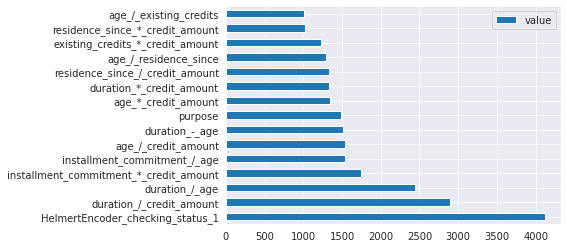

In [24]:
feature_importance.sort_values(by='value', ascending=False)[:15].plot(kind='barh')

### Save & Load CV!
export of cross-validation settings, including trained models and their settings

In [25]:
predicts = cv.predict_test(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.821


In [26]:
cv.save('cv_1',)

Save CrossValidation


In [27]:
cv_2 = CrossValidation(estimator=model,)

In [28]:
cv_2 = cv_2.load('cv_1',)

Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Finished loading model, total used 300 iterations
Load CrossValidation


In [29]:
predicts = cv_2.predict_test(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.821


## Optimizing Parameters
In this library, I tried to simplify the process of optimizing and iterating parameters as much as possible. You just specify how much time you are willing to spend on optimization, and the library will select the rules for cross-validation, optimization depth, and other optimization parameters based on this time. The more time you give it, the better it will be able to select parameters.    

[RUS]
В этой библиотеке я постарался максимально упростить процесс оптимизации и перебора параметров. Вы просто указываете сколько вы готовы потратить времени на оптимизацию, а библиотека сама подберет правила кроссвалидации, глубины оптимизации и прочии параметры оптимизации исходя из этого времени. Чем больше времени вы ей дадите, тем более качественней она сможет подобрать параметры.

In [30]:
history = model.opt(
    X=X_train,
    y=y_train,
    timeout=600, # optimization time in seconds,
    verbose=3
    )

00:40:52 | ##################################################
00:40:53 | > Step 1: calc parameters and pruned score: get test 10 trials
00:41:07 |  One iteration takes ~ 1.4 sec
00:41:07 |  Possible iters ~ 427.0
00:41:07 | --------------------------------------------------
00:41:07 |   Pruned Threshold Score: 0.6667
00:41:07 | ##################################################
00:41:07 | > Step 2: Full opt with Threshold Score Pruner
00:41:07 | ##################################################
00:41:07 | > Start optimization with the parameters:
00:41:07 | CV_Folds = 10
00:41:07 | Score_CV_Folds = 2
00:41:07 | Feature_Selection = False
00:41:07 | Opt_lvl = 2
00:41:07 | Cold_start = 20
00:41:07 | Early_stoping = 30
00:41:07 | Metric = roc_auc_score
00:41:07 | Direction = maximize
00:41:07 | ##################################################
Optimize: : 288it [04:12,  1.14it/s, | Model: LightGBM | OptScore: 0.728 | Best roc_auc_score: 0.7478 ]
00:45:19 | 
 EarlyStopping Exceeded: Best 

In [31]:
model.model_param

{'random_seed': 42,
 'num_iterations': 300,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary',
 'min_child_samples': 2,
 'learning_rate': 0.05497522496123994,
 'num_leaves': 3,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.6000000000000001,
 'bagging_freq': 7}

In [32]:
model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.7273


In [33]:
history.head(5)

,number,value,datetime_start,datetime_complete,duration,params_lgbm_bagging_fraction,params_lgbm_bagging_freq,params_lgbm_feature_fraction,params_lgbm_learning_rate,params_lgbm_min_child_samples,params_lgbm_num_iterations,params_lgbm_num_leaves,params_model_name,state
0,0,0.6548,2021-03-01 00:40:53.309829,2021-03-01 00:40:54.899922,0 days 00:00:01.590093,0.8,8.0,0.7,0.253700,7,300,20,LightGBM,COMPLETE
1,1,0.5578,2021-03-01 00:40:54.950166,2021-03-01 00:40:56.533020,0 days 00:00:01.582854,0.4,7.0,1.0,0.190304,2,500,12,LightGBM,COMPLETE
2,2,0.6287,2021-03-01 00:40:56.571935,2021-03-01 00:40:58.105819,0 days 00:00:01.533884,0.7,2.0,0.7,0.292157,2,400,13,LightGBM,COMPLETE
3,3,0.6938,2021-03-01 00:40:58.139005,2021-03-01 00:40:58.817753,0 days 00:00:00.678748,0.7,4.0,0.9,0.038962,14,500,2,LightGBM,COMPLETE
4,4,0.6689,2021-03-01 00:40:58.854124,2021-03-01 00:40:59.930184,0 days 00:00:01.076060,0.8,8.0,0.5,0.283368,7,300,8,LightGBM,COMPLETE


In [34]:
model.plot_opt_history()

# How it works
first let's look at all the parameters available to us     
для начала посмотрим все доступные нам параметры

```python
model = LightGBMClassifier(
                    model_param=None, # default model parameters
                    type_of_estimator=None, # classifier or regression
                    gpu=False, 
                    verbose=0,
                    random_state=RANDOM_SEED
    )
```

### *model_param*
parameters of the model itself. As you already understood, to work with the library itself, I use some kind of wrapper, but *model_param* pass the settings directly to the model itself

In [34]:
model.model_param

{'random_seed': 42,
 'num_iterations': 300,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary',
 'min_child_samples': 5,
 'learning_rate': 0.04,
 'num_leaves': 7,
 'bagging_fraction': 0.4,
 'feature_fraction': 0.6000000000000001,
 'bagging_freq': 10}

## Optimization

```python
history = model.opt(X,y,
            timeout=200, # optimization time in seconds
            metric=sklearn.metrics.roc_auc_score, # any metric from sklearn
            metric_round=4,
            direction='maximize', # optimization direction
            combined_score_opt=True, # score_opt = score - std
            iterations=None,
            cold_start=30,
            auto_parameters=True,
            folds=10, # Cross-validation folds
            score_folds=2, # how many folds are actually used for score
            opt_lvl=2,  # depth of selection of parameters
            early_stoping=100,  # stop otimization if no better parameters are found through iterations
            feature_selection=False,
            iteration_check=True,
            verbose=1,)
```

To optimize hyperparameters used Optuna (https://optuna.org), but with some modifications. Inside Optuna uses the TPE algorithm.

good visualization from: https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903
<img src="https://miro.medium.com/max/2000/1*m1JYCHHhbmn6TCHcJIklZA.gif" width="800">


### *metric* and *direction*
you can use standard metrics from sklearn.metrics or add custom metrics. Be sure to indicate the direction of improvement of the metric     

вы можете использовать стандартные метрики из sklearn.metrics или добавить кастомную. Обязательно указывайте направление улучшения метрики

### *cv* folds and *score_folds*
In training, I use cross validation. But if we don’t have much time, then we go to the trick, and learn only part of the folds (score_folds)    

В обучении я использую кросс валидацию. Но если у нас мало времени то мы идем на хитрость, и обучаемся только на части фолдов (score_folds)


### *cold_start*
In the *cold_start* parameter, we specify how many iterations we give for this warm-up.
before the algorithm starts searching for optimal parameters, it must collect statistics on the represented space.this is why it starts in the randomsample solution at the beginning. The longer it works in this mode , the less likely it is to get stuck in the local minimum. But if you take too long to warm up, you may not have time to search with a more "smart" algorithm. Therefore, it is important to maintain a balance. 

перед тем как алгоритм начинает поиск оптимальных параметров, он должен собрать статистику по представляемому пространству, по этому в начале он запускаеться в решиме randomsample. Чем дольше он проработает в этом режиме - тем меньше вероятность что он застрянет в локальном минимуме. Но если слишком долго делать прогрев - то может не остаться времени на поиск с более "умным" алгоритмом. Поэтому важно соблюдать баланс. В параметре cold_start указываем сколько итераций мы даем на этот прогрев. 

### *opt_lvl*
by limiting the optimization time, we will have to choose how deep we should optimize the parameters. Perhaps some parameters are not so important and can only give a fraction of a percent. By setting the opt_lvl parameter, you control the depth of optimization.

in the code *automl_alex.models.model_lightgbm.LightGBM* you can find how parameters are substituted for iteration:

```python
....
def get_model_opt_params(self, trial, model, opt_lvl, len_data, metric_name,):
        """
        Return:
            dict of DistributionWrappers
        """
        model_param = model._init_default_model_param()
        ################################# LVL 1 ########################################
        if opt_lvl == 1:
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 50,)
            
        if opt_lvl >= 1:
            if len_data > 1000:
                model_param['min_child_samples'] = trial.suggest_int('lgbm_min_child_samples', 2, \
                                                                        (len_data//100))
            else:
                model_param['min_child_samples'] = trial.suggest_int('lgbm_min_child_samples', 2, 7)

        ################################# LVL 2 ########################################
        if opt_lvl == 2:
            model_param['learning_rate'] = trial.suggest_int('lgbm_learning_rate', 1, 11)/100
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 50,)
            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 5,)*100

        if opt_lvl >= 2:
            model_param['bagging_fraction'] = trial.suggest_discrete_uniform('lgbm_bagging_fraction', 0.4, 1., 0.1)
            if model_param['bagging_fraction'] < 1.:
                model_param['feature_fraction'] = trial.suggest_discrete_uniform('lgbm_feature_fraction', 0.3, 1., 0.1)
                model_param['bagging_freq'] = trial.suggest_int('lgbm_bagging_freq', 2, 11,)
        
        ################################# LVL 3 ########################################
        if opt_lvl == 3:
            model_param['learning_rate'] = trial.suggest_int('lgbm_learning_rate', 1, 100)/1000
            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 11,)*100
        
        if opt_lvl >= 3:
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 100,)
        
        ################################# LVL 4 ########################################
        if opt_lvl == 4:
            model_param['learning_rate'] = trial.suggest_loguniform('lgbm_learning_rate', 1e-3, .1)

        if opt_lvl >= 4:
            model_param['boosting'] = trial.suggest_categorical('lgbm_boosting', ['gbdt', 'dart',])
            if model_param['boosting'] == 'dart':
                model_param['early_stopping_rounds'] = 0
                model_param['uniform_drop'] = trial.suggest_categorical('lgbm_uniform_drop', [True, False])
                model_param['xgboost_dart_mode'] = trial.suggest_categorical('lgbm_xgboost_dart_mode', [True, False])
                model_param['drop_rate'] = trial.suggest_loguniform('lgbm_drop_rate', 1e-8, 1.0)
                model_param['max_drop'] = trial.suggest_int('lgbm_max_drop', 0, 100)
                model_param['skip_drop'] = trial.suggest_loguniform('lgbm_skip_drop', 1e-3, 1.0)

            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 6,)*1000

            if model.type_of_estimator == 'classifier':
                model_param['objective'] = trial.suggest_categorical('lgbm_objective', 
                    [
                    'binary', 
                    'cross_entropy',
                    ])

            elif model.type_of_estimator == 'regression':
                model_param['objective'] = trial.suggest_categorical('lgbm_objective', 
                    [
                    'regression',
                    'regression_l1',
                    'mape',
                    'huber',
                    'quantile',
                    ])

        ################################# LVL 5 ########################################
        if opt_lvl >= 5:
            model_param['max_cat_threshold'] = trial.suggest_int('lgbm_max_cat_threshold', 1, 100)
            model_param['min_child_weight'] = trial.suggest_loguniform('lgbm_min_child_weight', 1e-6, 1.0)
            model_param['learning_rate'] = trial.suggest_loguniform('lgbm_learning_rate', 1e-5, .1)
            model_param['reg_lambda'] = trial.suggest_loguniform('lgbm_reg_lambda', 1e-8, 1.0)
            model_param['reg_alpha'] = trial.suggest_loguniform('lgbm_reg_alpha', 1e-8, 1.0)
            model_param['max_bin'] = trial.suggest_int('lgbm_max_bin', 1, 5,)*50
            #self.model_param['extra_trees'] = trial.suggest_categorical('lgbm_extra_trees', [True, False])
            model_param['enable_bundle'] = trial.suggest_categorical('lgbm_enable_bundle', [True, False])

        ################################# Other ########################################
        if model.type_of_estimator == 'classifier':
            if metric_name not in ['roc_auc_score', 'log_loss', 'brier_score_loss']:
                model_param['scale_pos_weight'] = trial.suggest_discrete_uniform('lgbm_scale_pos_weight', 0.1, 1., 0.1)

        return(model_param)
...
```

ограничивая время оптимизации, нам придется выбирать насколько глубоко мы должны оптимизировать параметры. Возможно некоторые параметры не так важны и могут дать лишь доли процента. Устанавливая параметр opt_lvl вы регулируете глубину оптимизации.

### *auto_parameters*
If we don't want to select anything, we just set *auto_parameters=True*. Then the algorithm itself will select, depending on the time allotted to it, the optimal values for:
* folds
* score_folds
* cold_start
* opt_lvl

Если мы не хотим ни чего подбирать, то просто устанавливаем auto_parameters=True. Тогда алгоритм сам подберет, в зависимости от выделенного ему времени, оптимальные значения этих параметров.

# Regression

In [35]:
from sklearn.datasets import load_boston
data = load_boston()
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(data.data), 
                                                    pd.DataFrame(data.target), 
                                                    test_size=0.15, 
                                                    random_state=RANDOM_SEED,)

X_train.shape, X_test.shape

((430, 13), (76, 13))

In [36]:
from automl_alex import LightGBM, LightGBMRegressor

# We will use LightGBM for this dataset
model = LightGBM(type_of_estimator='regression', random_state=RANDOM_SEED)

# or Simply
model = LightGBMRegressor(random_state=RANDOM_SEED)

In [37]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test MSE: ', sklearn.metrics.mean_squared_error(y_test, predicts))

Test MSE:  5.791601700931619


In [38]:
history = model.opt(X_train, y_train, timeout=600,)

Optimize: : 145it [10:00,  4.14s/it,  | Model: LightGBM | OptScore: 0.7061 | Best mean_squared_error: 0.7061 +- 0.073893]


In [39]:
history.head(5)

,score_opt,model_score,score_std,model_name,model_param,columns,cv_folds
25,0.7061,0.7061,0.073893,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[checking_status, duration, credit_history, pu...",10
6,0.7080,0.7080,0.048595,LightGBM,"{'random_seed': 42, 'num_iterations': 400, 've...","[checking_status, duration, credit_history, pu...",10
8,0.7097,0.7097,0.047513,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[checking_status, duration, credit_history, pu...",10
20,0.7108,0.7108,0.046799,LightGBM,"{'random_seed': 42, 'num_iterations': 600, 've...","[checking_status, duration, credit_history, pu...",10
40,0.7112,0.7112,0.039980,LightGBM,"{'random_seed': 42, 'num_iterations': 400, 've...","[checking_status, duration, credit_history, pu...",10


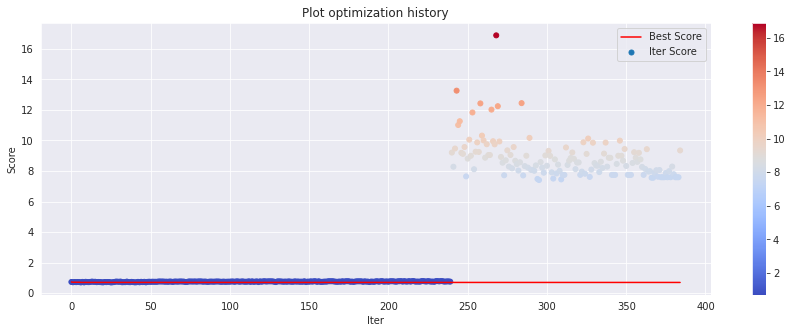

In [40]:
model.plot_opt_history()

In [41]:
model.model_param

{'random_seed': 42,
 'num_iterations': 500,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary',
 'min_child_samples': 3,
 'learning_rate': 0.08,
 'num_leaves': 16,
 'bagging_fraction': 0.6000000000000001,
 'feature_fraction': 0.7,
 'bagging_freq': 10}

In [42]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test MSE: ', sklearn.metrics.mean_squared_error(y_test, predicts))

Test MSE:  491.6176315789474


# Advanced Use

In [13]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
# convert target to binary
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((39073, 14), (9769, 14))

In [15]:
de = DataPrepare(random_state=RANDOM_SEED)
X_train = de.fit_transform(X_train)
X_test = de.transform(X_test)

23:05:32 | Source data shape: (39073, 14)
23:05:32 | ##################################################
23:05:32 | ! START preprocessing Data
23:05:32 | - Auto detect cat features: 12
23:05:32 | > Binary Features
23:05:32 | > Clean Categorical Features
23:05:32 | > Transform Categorical Features.
23:05:34 |  - Encoder: HelmertEncoder ADD features: 123
23:05:34 |  - Encoder: CountEncoder ADD features: 12
23:05:34 | > CleanOutliers
23:05:34 | Num of outlier detected: 560 in Feature fnlwgt
23:05:34 | Proportion of outlier detected: 1.4 %
23:05:34 | Num of outlier detected: 253 in Feature education-num
23:05:34 | Proportion of outlier detected: 0.6 %
23:05:34 |   No nans features
23:05:34 | > Generate interaction Num Features
23:05:34 |  ADD features: 3
23:05:34 | > Normalization Features
23:05:35 | > Reduce_Memory
23:05:35 | Memory usage of dataframe is 44.12 MB
23:05:35 | Memory usage after optimization is: 22.62 MB
23:05:35 | Decreased by 48.7%
23:05:35 | ###############################

In [16]:
model = LightGBMClassifier(random_state=RANDOM_SEED)
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

Test metric:  4.9286


## Advanced opt

In [47]:
history = model.opt(
            X_train, y_train,
            metric=sklearn.metrics.log_loss, # log_loss
            direction='minimize', # changed optimization direction for log_loss
            combined_score_opt=True, # in 'minimize' score_opt = score + std
            timeout=1000, # sec
            auto_parameters=False, # try to set the rules ourselves
            folds=10,
            score_folds=3, # put 3 folds
            cold_start=50, # I plan > 200 iterations. 50 iterations are enough to evaluate the space
            opt_lvl=3,
            early_stoping=100, # stop otimization if no better parameters are found through iterations
            verbose=1,)

01:03:45 | An error has been caught in function '<module>', process 'MainProcess' (94111), thread 'MainThread' (139974332950336):
Traceback (most recent call last):

  File "/home/lek/.vscode/extensions/ms-toolsai.jupyter-2021.2.576440691/pythonFiles/vscode_datascience_helpers/../pyvsc-run-isolated.py", line 24, in <module>
    runpy.run_path(module, run_name="__main__")
    │     │        └ '/home/lek/.vscode/extensions/ms-toolsai.jupyter-2021.2.576440691/pythonFiles/vscode_datascience_helpers/kernel_prewarm_start...
    │     └ <function run_path at 0x7f4e4fe79d30>
    └ <module 'runpy' from '/home/lek/anaconda3/envs/ds/lib/python3.8/runpy.py'>

  File "/home/lek/anaconda3/envs/ds/lib/python3.8/runpy.py", line 265, in run_path
    return _run_module_code(code, init_globals, run_name,
           │                │     │             └ '__main__'
           │                │     └ None
           │                └ <code object <module> at 0x7f4e4fe922f0, file "/home/lek/.vscode/extens

In [48]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

Test metric:  4.9781


In [49]:
model.plot_opt_history()

AttributeError: 'LightGBMClassifier' object has no attribute 'direction'

## Feature Important from CV

In [ ]:
res = model.cross_validation(
            X=X_train,
            y=y_train,
            get_feature_importance=True,)
#res['Feature_importance']

In [ ]:
pd.Series(res['feature_importance'], index=res['feature_importance'].keys()).sort_values(ascending=False)[:15].plot(kind='barh')

## Predict from configs

In [ ]:
top5_models = history.drop_duplicates(subset=['model_score', 'score_std'], keep='last').head(5)
top5_models

In [ ]:
# let's load the 2nd model
model.model_param = top5_models['model_param'].iloc[1] 

In [ ]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

# Full Save & Load

### Save

In [17]:
de.save('de_model_1',)

In [18]:
model.save('model_1',)

In [19]:
model.model_param

{'random_seed': 42,
 'num_iterations': 300,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary'}

In [20]:
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

Test metric:  4.9286


### Load
you can restart the notebook to start from this place - to make sure

In [1]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare
from automl_alex import LightGBM, LightGBMClassifier

RANDOM_SEED = 42
print(automl_alex.__version__)

1.2.26


In [2]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)

de = DataPrepare(random_state=RANDOM_SEED, verbose=0)
de = de.load('de_model_1', )
X_test = de.transform(X_test)

23:06:23 | ##################################################
23:06:23 | ! Start Transform Data
23:06:23 | > Clean Binary Features
23:06:23 | > Clean Categorical Features
23:06:23 | > Transform Categorical Features.
23:06:23 |  - Encoder: HelmertEncoder ADD features: 123
23:06:23 |  - Encoder: CountEncoder ADD features: 12
23:06:23 | > Generate interaction Num Features
23:06:23 |  ADD features: 3
23:06:23 | > Normalization Features
23:06:24 | > Reduce_Memory
23:06:24 | Memory usage of dataframe is 11.03 MB
23:06:24 | Memory usage after optimization is: 5.66 MB
23:06:24 | Decreased by 48.7%
23:06:24 | ##################################################
23:06:24 | Final data shape: (9769, 154)
23:06:24 | Total ADD columns: 140
23:06:24 | ##################################################


In [3]:
model_new = LightGBMClassifier(random_state=RANDOM_SEED)
model_new = model_new.load('model_1',)

predicts = model_new.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

Test metric:  4.9286


In [4]:
model_new.model_param

{'random_seed': 42,
 'num_iterations': 300,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary'}